## **1. Dataset Load**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/google colab/kaggle.json" ~/.kaggle/

In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 98% 419M/428M [00:02<00:00, 209MB/s]
100% 428M/428M [00:02<00:00, 194MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/toronto-emotional-speech-set-tess.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/google colab/Speech_Emotion_Recognition_Project/data')
zip_ref.close()

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio

import tensorflow as tf
tf.random.set_seed(42)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

!pip install -U keras-tuner
import kerastuner as kt



import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


<ipython-input-2-30c63bb24025>:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
main_path = r'/content/drive/MyDrive/google colab/Speech_Emotion_Recognition_Project'
data_path = os.path.join(main_path, 'data/TESS Toronto emotional speech set data')
models_path = os.path.join(main_path, 'models')

In [ ]:
from os.path import dirname
paths = []
labels = []

for direname in os.listdir(data_path):
  complete_dir_path = os.path.join(data_path, direname)

  for filename in os.listdir(complete_dir_path):
    complete_file_path = os.path.join(complete_dir_path, filename)

    emotion_label = (filename.split('_')[-1][:-4]).lower()
    paths.append(complete_file_path)
    labels.append(emotion_label)


In [ ]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/google colab/Speech_Emo...,fear
1,/content/drive/MyDrive/google colab/Speech_Emo...,fear
2,/content/drive/MyDrive/google colab/Speech_Emo...,fear
3,/content/drive/MyDrive/google colab/Speech_Emo...,fear
4,/content/drive/MyDrive/google colab/Speech_Emo...,fear


In [ ]:
df['label'].value_counts()      # pleasant surprise = ps

,count
label,
fear,400
ps,400
sad,400
angry,400
disgust,400
happy,400
neutral,400


## **2. Exploratory Data Analysis**

<Axes: xlabel='label', ylabel='count'>

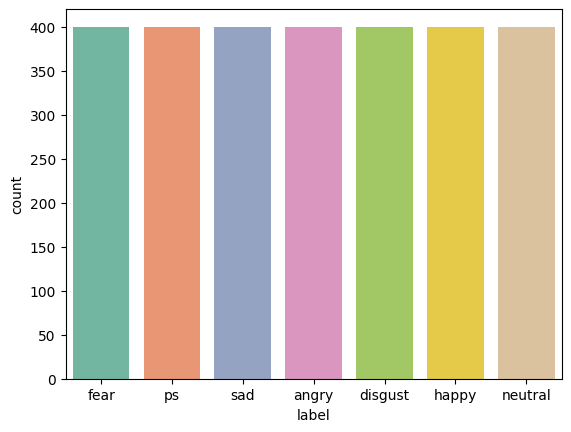

In [ ]:
sns.countplot(x = df['label'], palette='Set2')

In [ ]:
def waveplot(data, sample_rate, emotion):
  plt.figure(figsize=(12,3))
  plt.title(emotion, size=20)
  librosa.display.waveshow(data, sr=sample_rate)
  plt.show()

def spectogram(data, sample_rate, emotion):
  x = librosa.stft(data)
  xdb = librosa.amplitude_to_db(abs(x))

  plt.figure(figsize=(12,3))
  plt.title(emotion, size=20)
  librosa.display.specshow(xdb, sr=sample_rate, x_axis = 'time', y_axis='hz')
  plt.show()

In [ ]:
# Extract the first file from 7 classes
emotion = list(set(labels))
path = [np.array(df['speech'][df['label'] == emotion[i]])[0] for i in range(len(emotion))]

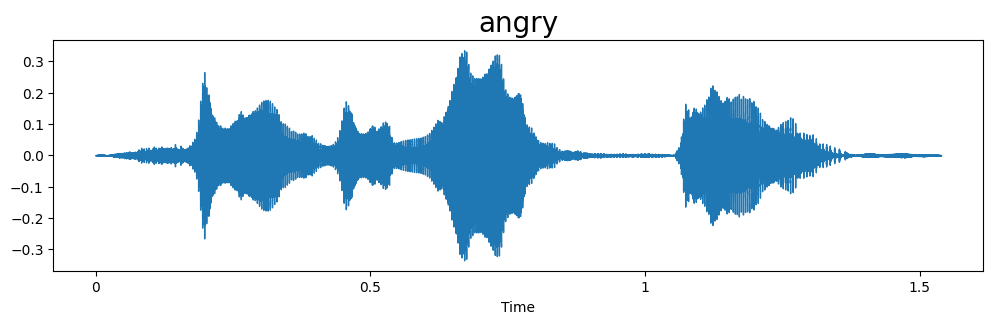

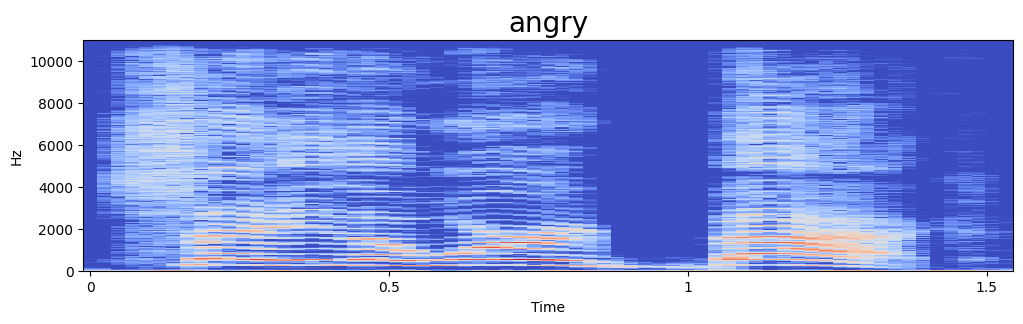

In [ ]:
index = 0
data, sample_rate = librosa.load(path[index])
waveplot(data, sample_rate, emotion[index])
spectogram(data, sample_rate, emotion[index])
Audio(path[index], rate=sample_rate)

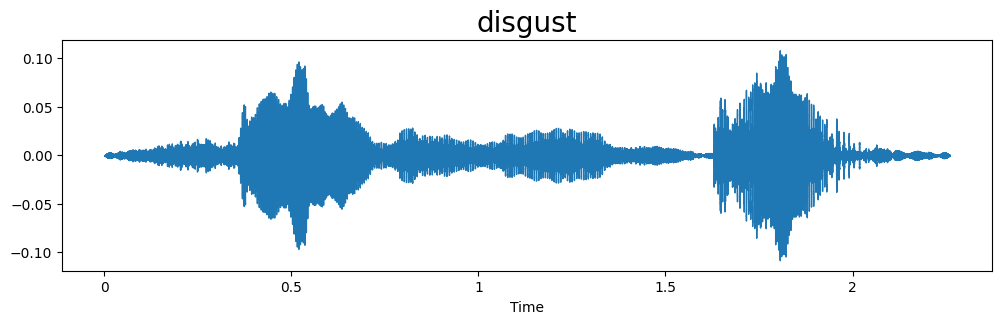

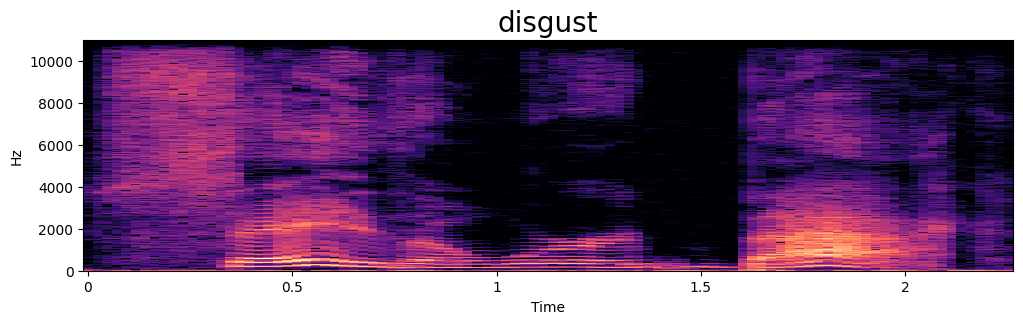

In [ ]:
index = 1
data, sample_rate = librosa.load(path[index])
waveplot(data, sample_rate, emotion[index])
spectogram(data, sample_rate, emotion[index])
Audio(path[index], rate=sample_rate)

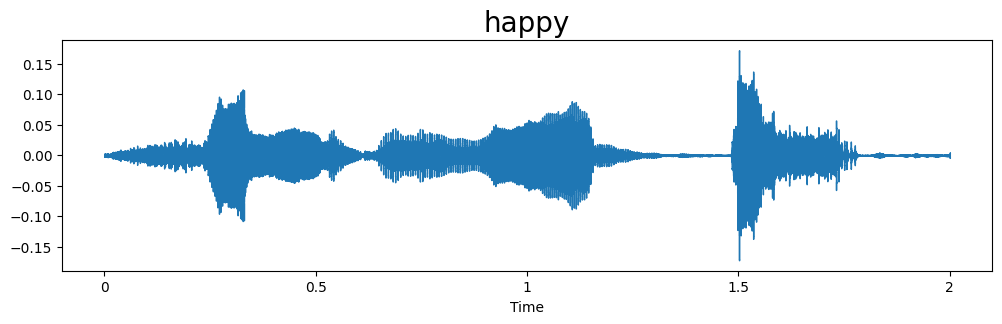

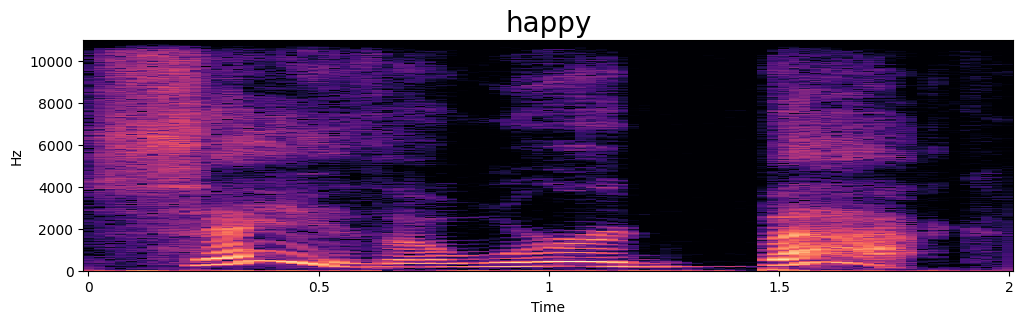

In [ ]:
index = 2
data, sample_rate = librosa.load(path[index])
waveplot(data, sample_rate, emotion[index])
spectogram(data, sample_rate, emotion[index])
Audio(path[index], rate=sample_rate)

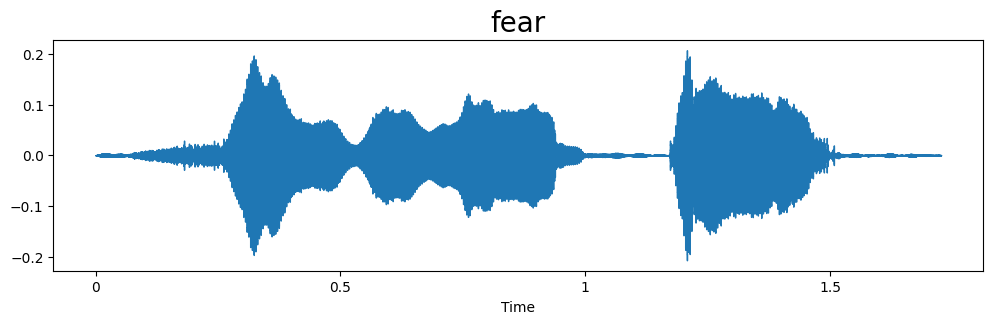

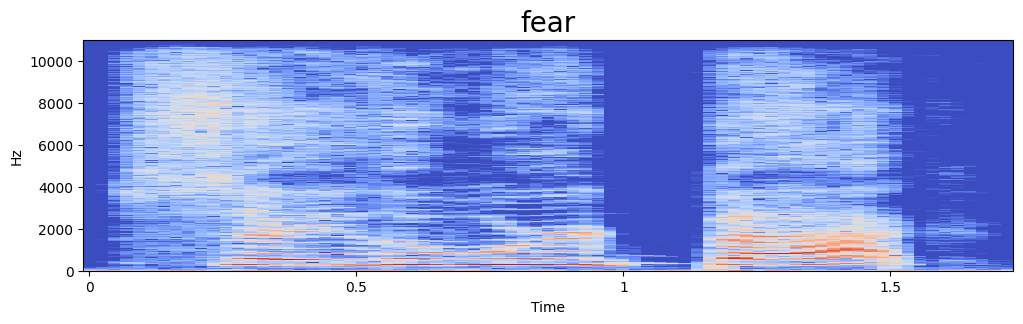

In [ ]:
index = 3
data, sample_rate = librosa.load(path[index])
waveplot(data, sample_rate, emotion[index])
spectogram(data, sample_rate, emotion[index])
Audio(path[index], rate=sample_rate)

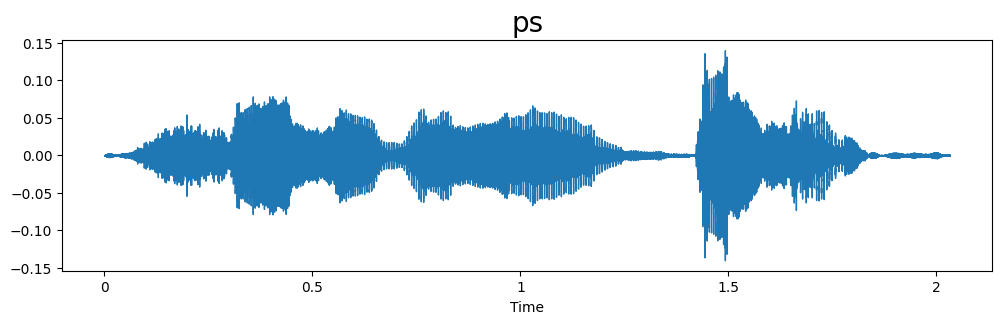

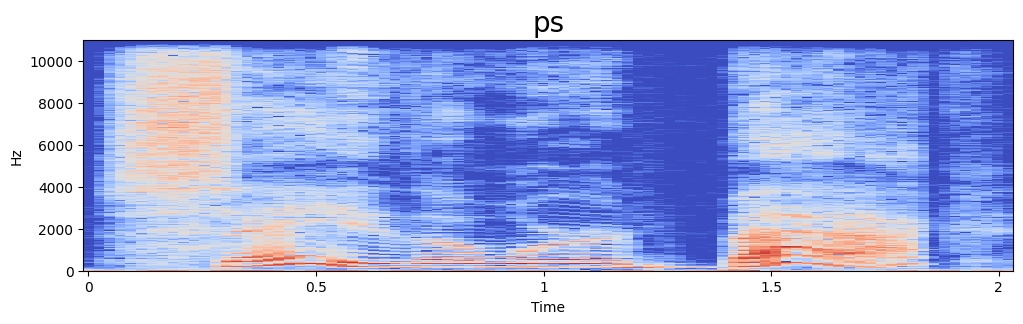

In [ ]:
index = 4
data, sample_rate = librosa.load(path[index])
waveplot(data, sample_rate, emotion[index])
spectogram(data, sample_rate, emotion[index])
Audio(path[index], rate=sample_rate)

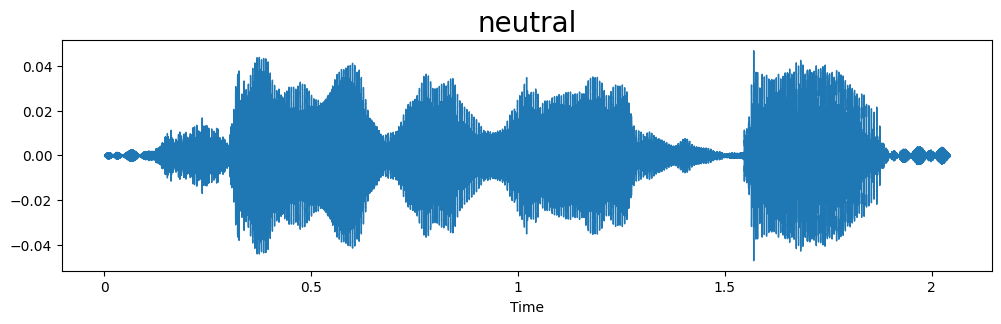

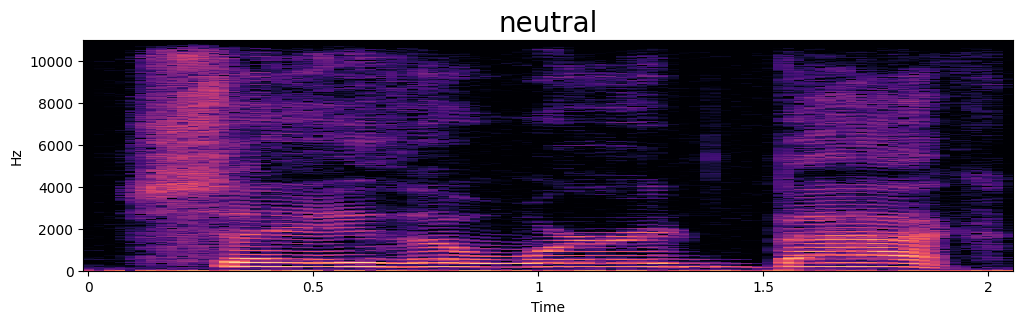

In [ ]:
index = 5
data, sample_rate = librosa.load(path[index])
waveplot(data, sample_rate, emotion[index])
spectogram(data, sample_rate, emotion[index])
Audio(path[index], rate=sample_rate)

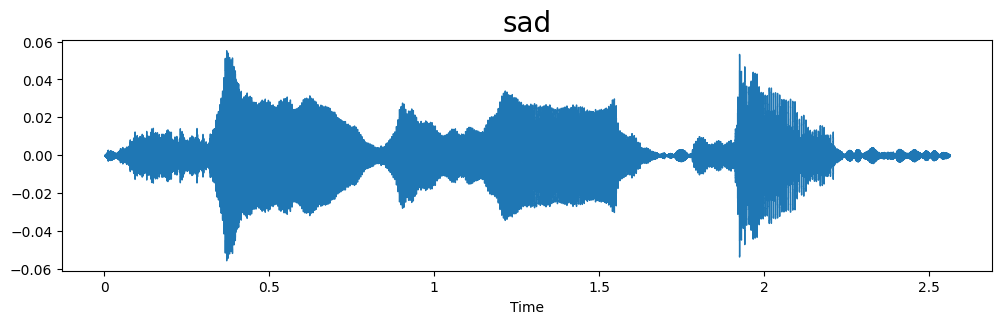

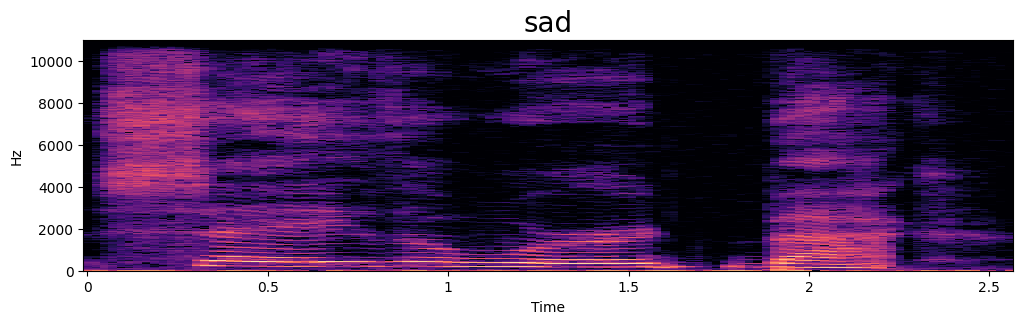

In [ ]:
index = 6
data, sample_rate = librosa.load(path[index])
waveplot(data, sample_rate, emotion[index])
spectogram(data, sample_rate, emotion[index])
Audio(path[index], rate=sample_rate)

## **3. Feature Extraction**

In [ ]:
def extract_mfcc(filename):
  y, sample_rate = librosa.load(filename, duration=3, offset=0.5)
  mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=40).T, axis=0)
  return mfcc

In [ ]:
extract_mfcc(df['speech'][0])

array([-4.4536737e+02,  9.1276100e+01, -5.8949184e-01, -1.7314266e+01,
        3.2114551e+00,  3.8689063e+00, -1.2856503e+01, -3.4997184e-02,
       -1.0514206e+01,  1.8963062e+00, -1.3004946e+01, -7.5758567e+00,
       -6.3761382e+00, -3.0671549e+00, -2.8966866e+00,  2.5014246e+00,
       -6.5666761e+00,  2.3161001e+00,  3.9002411e+00, -7.2122092e+00,
        6.1384783e+00,  1.8507450e+01,  1.5220099e+01,  2.9525787e+01,
        2.1546635e+01,  1.7631252e+01,  7.3770423e+00,  2.2608619e+00,
       -2.9354761e+00,  6.0986023e+00,  5.5288839e-01,  2.1243880e+00,
       -2.8407269e+00, -4.6624751e+00,  8.0207366e-01,  3.1533179e+00,
       -2.4966428e+00, -1.1518216e+00, -2.2240901e+00,  2.2110422e+00],
      dtype=float32)

In [ ]:
x_mfcc = df['speech'].apply(lambda x:extract_mfcc(x))

In [ ]:
x_mfcc.head()

,speech
0,"[-445.36737, 91.2761, -0.58949184, -17.314266,..."
1,"[-456.2984, 95.33353, 17.71685, -33.765804, -1..."
2,"[-461.2538, 56.51359, 13.970672, 2.563786, 8.1..."
3,"[-412.7426, 85.44517, 7.658597, -21.482409, -0..."
4,"[-499.15588, 72.94784, 25.2297, 8.166257, 11.4..."


In [ ]:
X = [x for x in x_mfcc]
X = np.array(X)
X.shape


(2800, 40)

In [ ]:
## input split
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [ ]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
print(y.shape)

(2800, 7)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print("shape of X_train is", X_train.shape)
print("shape of y_train is", y_train.shape)
print("shape of X_test is", X_test.shape)
print("shape of y_test is", y_test.shape)

shape of X_train is (2380, 40, 1)
shape of y_train is (2380, 7)
shape of X_test is (420, 40, 1)
shape of y_test is (420, 7)


## **4. Custom Model Creation**

In [ ]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(40,1)),
    LSTM(256),
    Dropout(0.2),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 831,111 (3.17 MB)

 Trainable params: 831,111 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_path = os.path.join(models_path, 'Custom_CNN_model')
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.20, epochs=100, batch_size=64, callbacks=callbacks)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4604 - loss: 1.4061
Epoch 1: val_loss improved from inf to 0.42011, saving model to /content/drive/MyDrive/google colab/Speech_Emotion_Recognition_Project/models/Custom_CNN_model/Custom_CNN_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4661 - loss: 1.3923 - val_accuracy: 0.8487 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 2/100
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8745 - loss: 0.3839
Epoch 2: val_loss improved from 0.42011 to 0.28655, saving model to /content/drive/MyDrive/google colab/Speech_Emotion_Recognition_Project/models/Custom_CNN_model/Custom_CNN_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8775 - loss: 0.3737 - val_accuracy: 0.9055 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 3/100
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8931 - loss: 0.3006
Epoch 3: val_loss did not improve from 0.28655
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accur

In [ ]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

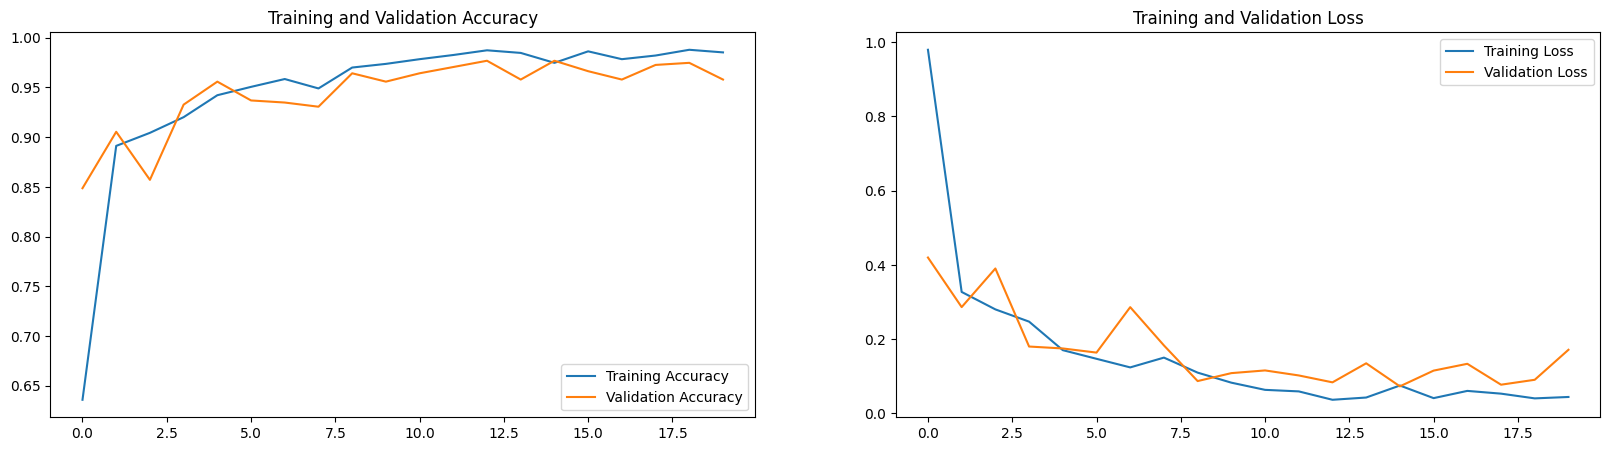

In [ ]:
plot_history(history)

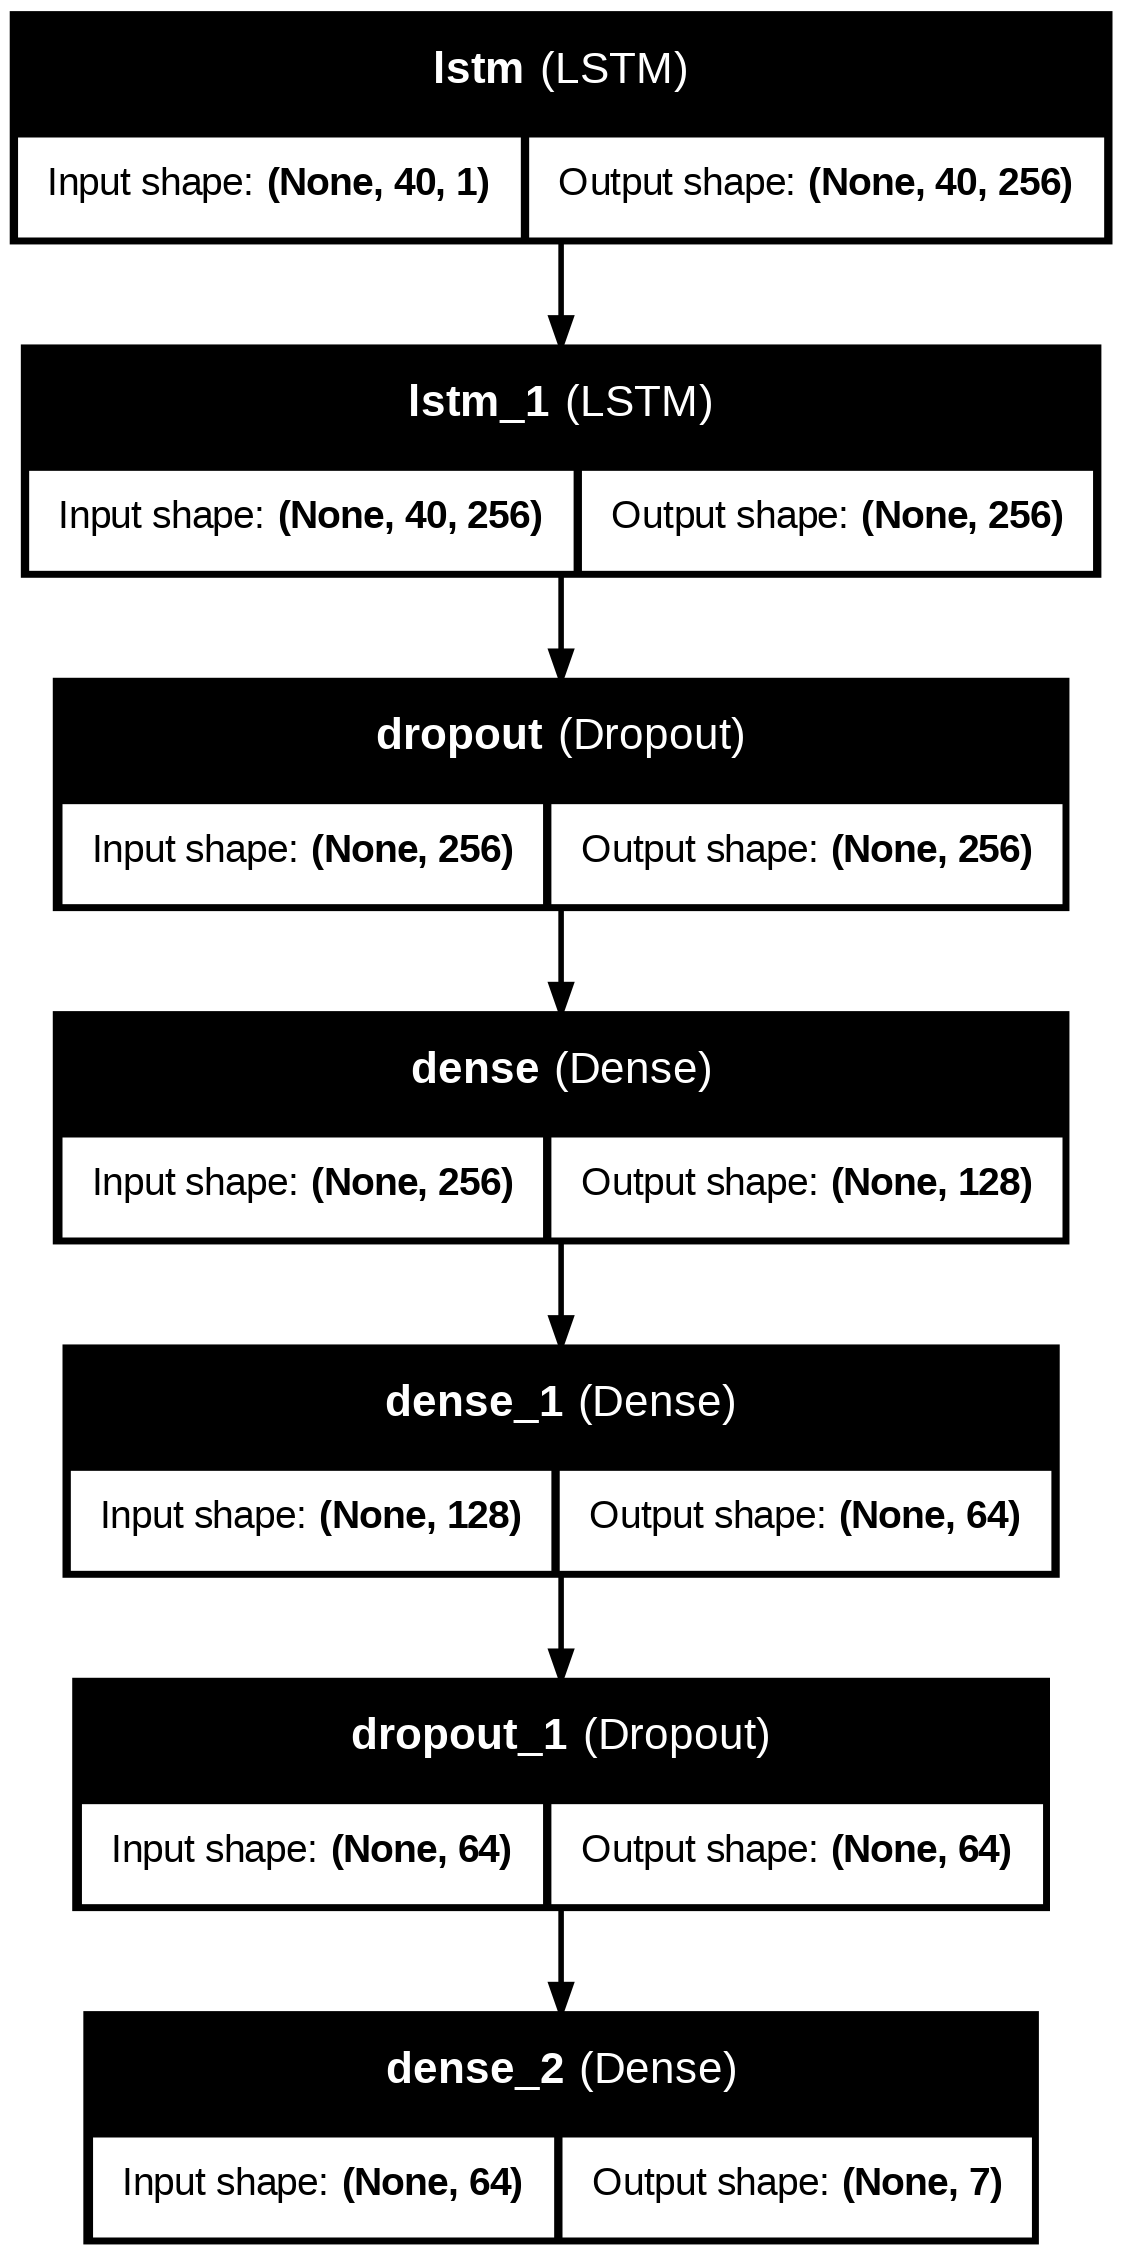

In [ ]:

plot_model(model, to_file = '/content/drive/MyDrive/google colab/Speech_Emotion_Recognition_Project/models/Custom_CNN_model/Architecture.png',
           show_shapes=True, show_layer_names=True)

### **Model Evaluation**

In [ ]:
y_true = np.argmax(y_test, axis=1)

y_pred = np.argmax(model.predict(X_test), axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


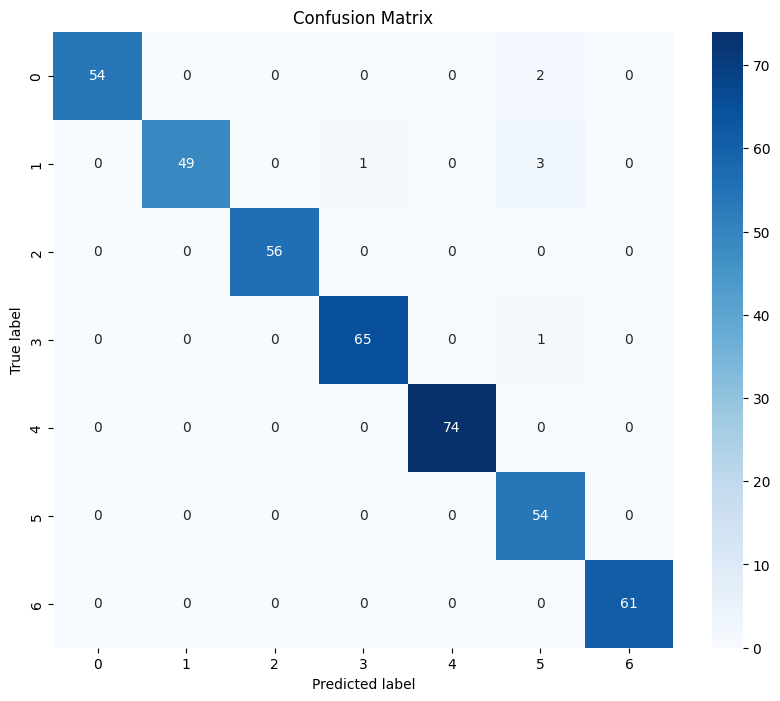

In [ ]:

class_labels = []
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       1.00      0.92      0.96        53
           2       1.00      1.00      1.00        56
           3       0.98      0.98      0.98        66
           4       1.00      1.00      1.00        74
           5       0.90      1.00      0.95        54
           6       1.00      1.00      1.00        61

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420



## **5. Custom Tuned Model Creation**

In [ ]:
def build_model(hp):

  model = Sequential()

  model.add(LSTM(256, return_sequences=True, input_shape=(40,1)))

  nums_of_lstm_layers = hp.Int('Number of LSTM Layers', min_value=3, max_value=7)
  for i in range(nums_of_lstm_layers):
    units = hp.Choice('LSTM Layer units', values=[64,128,256])

    is_return_sequence = True if i < nums_of_lstm_layers - 1 else False
    model.add(LSTM(units, return_sequences=is_return_sequence))

  ratio = hp.Choice('lstm DropOut Ratio', values= [0.2, 0.3, 0.4, 0.5])
  model.add(Dropout(ratio))

  for i in range(hp.Int('Number of Dense Layers', min_value=3, max_value=7)):
    units = hp.Choice('Dense Layer units', values=[64,128,256])

    model.add(Dense(units, activation='relu'))

  ratio = hp.Choice('Dense DropOut Ratio', values= [0.2, 0.3, 0.4, 0.5])
  model.add(Dense(7, activation='softmax'))


  model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
  return model

In [ ]:
cnn_path = os.path.join(models_path, 'Custom_Tuned_CNN_model')
name = 'Custom_Tuned_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [ ]:
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=10)

tuner.search(X_train, y_train,validation_split=0.2, epochs=5, batch_size=64)

Trial 10 Complete [00h 00m 20s]
val_loss: 0.38708627223968506

Best val_loss So Far: 0.21483056247234344
Total elapsed time: 00h 03m 21s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'Number of LSTM Layers': 4,
 'LSTM Layer units': 64,
 'lstm DropOut Ratio': 0.5,
 'Number of Dense Layers': 3,
 'Dense Layer units': 64,
 'Dense DropOut Ratio': 0.5}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]       # select first best model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 40, 64)              │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 40, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 40, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 458,375 (1.75 MB)

 Trainable params: 458,375 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, validation_split=0.2, initial_epoch=5, epochs=100, batch_size=64, callbacks=callbacks)

Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8851 - loss: 0.3716
Epoch 6: val_loss improved from inf to 0.26718, saving model to /content/drive/MyDrive/google colab/Speech_Emotion_Recognition_Project/models/Custom_Tuned_CNN_model/Custom_Tuned_CNN_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8851 - loss: 0.3711 - val_accuracy: 0.9139 - val_loss: 0.2672 - learning_rate: 0.0010
Epoch 7/100
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9340 - loss: 0.2355
Epoch 7: val_loss did not improve from 0.26718
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9340 - loss: 0.2340 - val_accuracy: 0.9013 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 8/100
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9135 - loss: 0.2754
Epoch 8: val_loss improved from 0.26718 to 0.16908, saving model to /content/drive/MyDrive/google colab/Speech_Emotion_Recognition_Project/models/Custom_Tuned_CNN_model/Custom_Tuned_CNN_model.keras
30/30 ━━━━━━━━━━━━━━━━━

In [ ]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

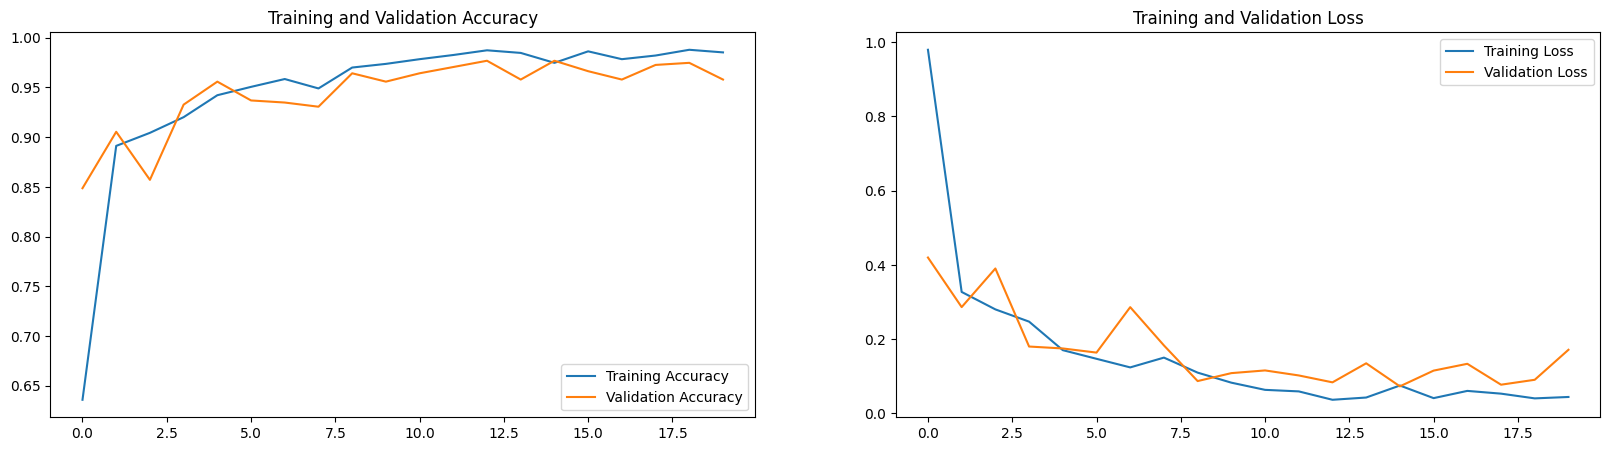

In [ ]:
plot_history(history)

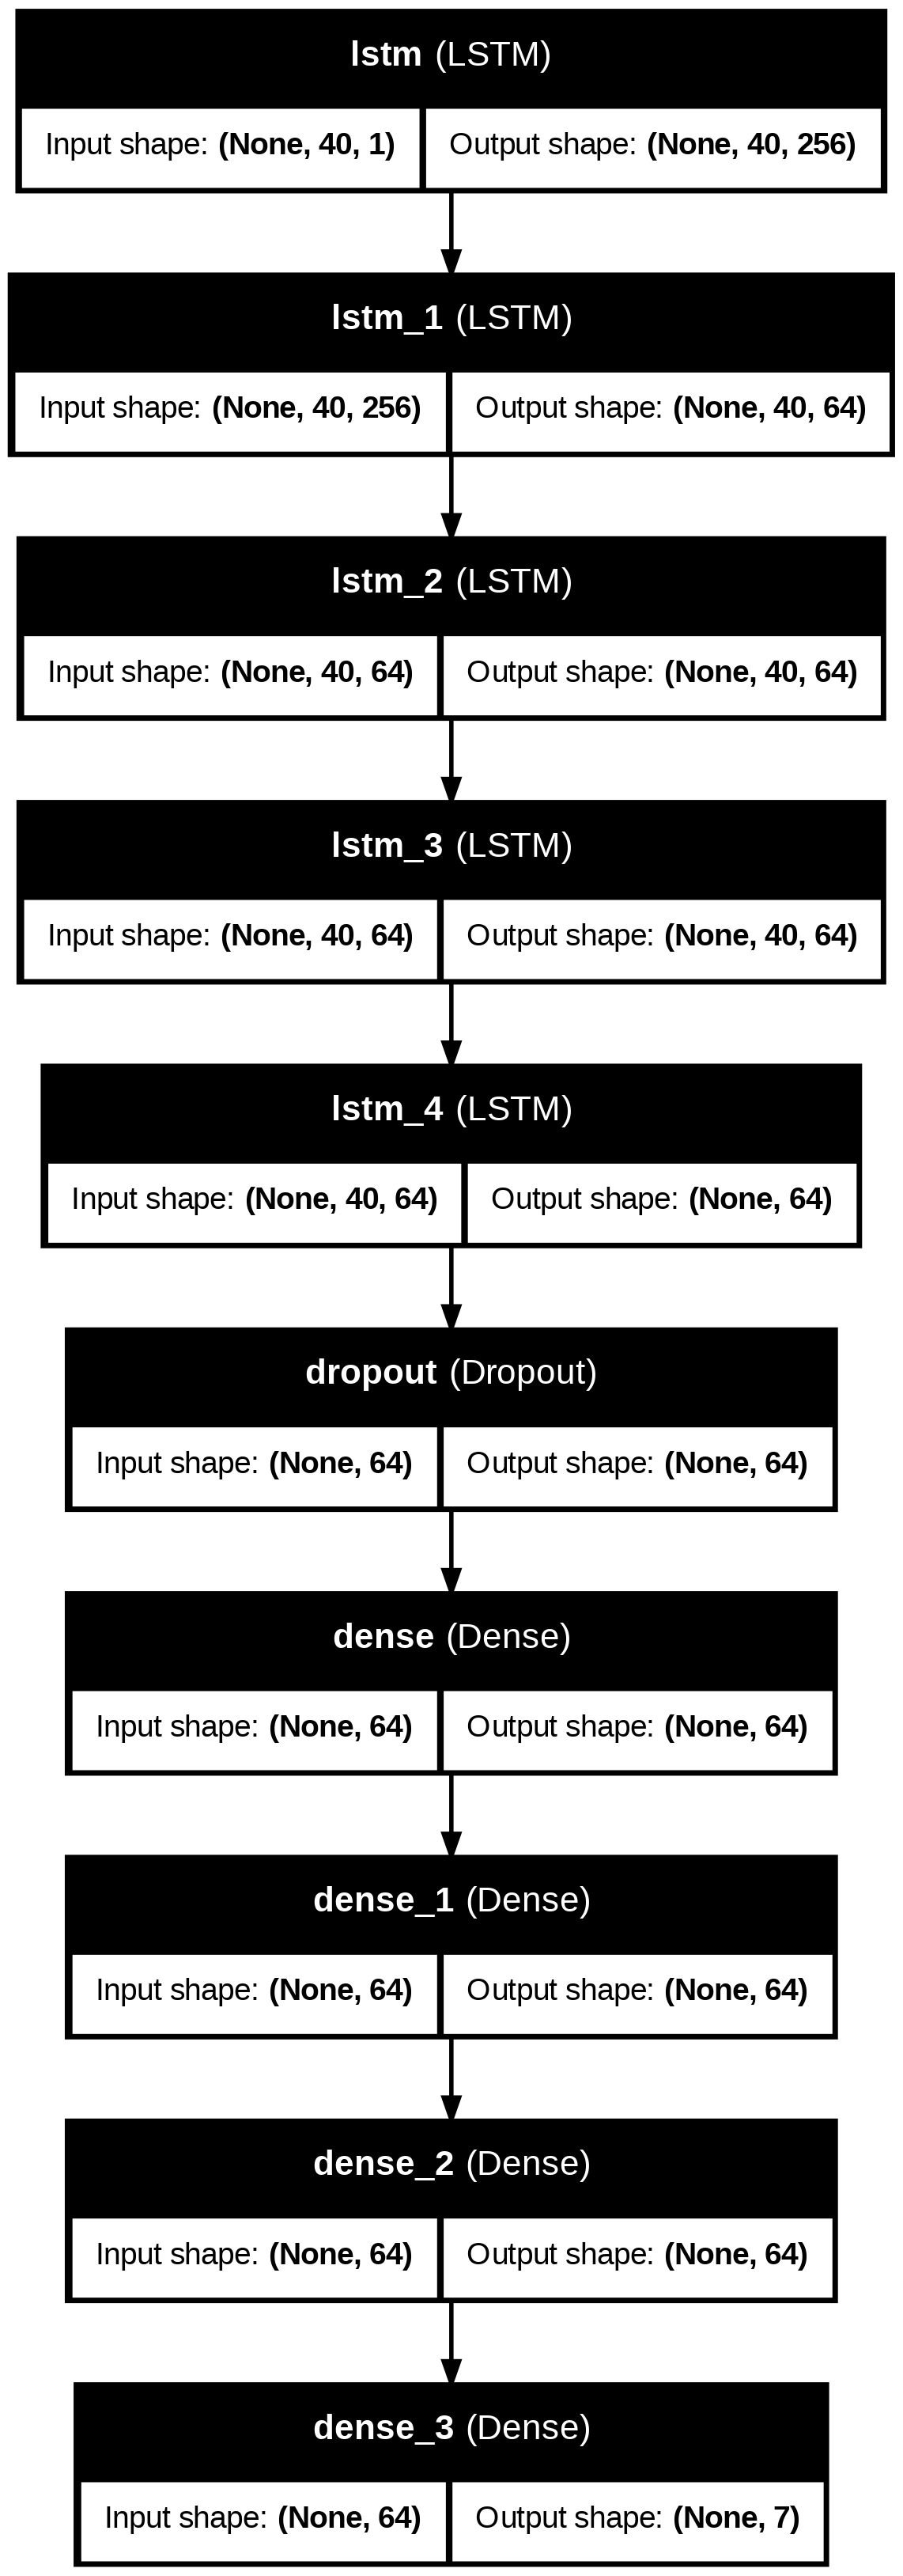

In [ ]:
plot_model(model, to_file = '/content/drive/MyDrive/google colab/Speech_Emotion_Recognition_Project/models/Custom_Tuned_CNN_model/Architecture.png',
           show_shapes=True, show_layer_names=True)

### **Model Evaluation**

In [ ]:
y_true = np.argmax(y_test, axis=1)

y_pred = np.argmax(model.predict(X_test), axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


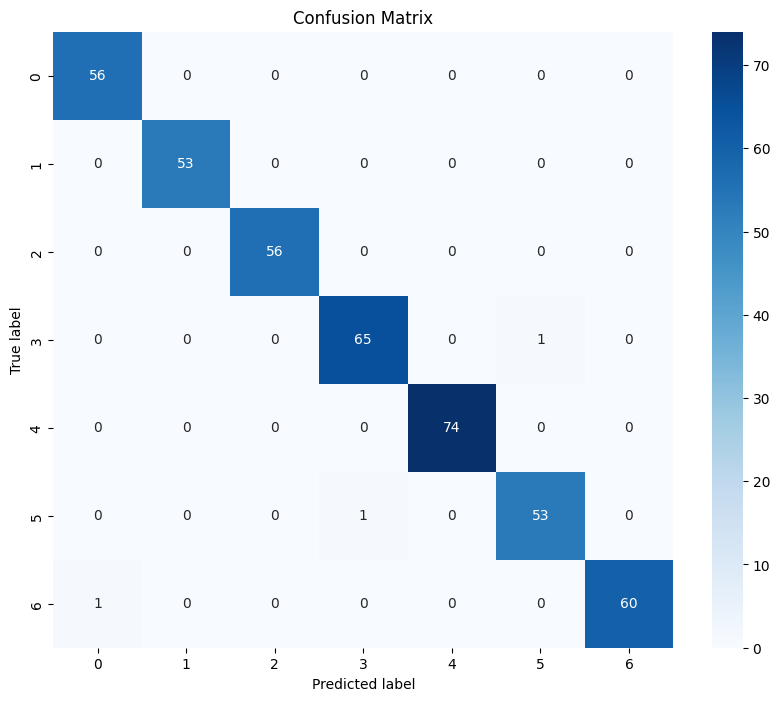

In [ ]:
class_labels = []
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        56
           1       1.00      1.00      1.00        53
           2       1.00      1.00      1.00        56
           3       0.98      0.98      0.98        66
           4       1.00      1.00      1.00        74
           5       0.98      0.98      0.98        54
           6       1.00      0.98      0.99        61

    accuracy                           0.99       420
   macro avg       0.99      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420

